## 🏭 Problem: Dardanel Üretim Hattında İşçi-Makine Eşleştirme

### 🎯 Soru:

Dardanel firması, Çanakkale’deki üretim tesisinde 30 farklı makineyle çalışmaktadır. Bu makineler; konserveleme, pişirme, etiketleme ve paketleme gibi farklı üretim tiplerinde görev almaktadır. Her makinenin birim zamanda üretim kapasitesi farklıdır.

Fabrikada çalışan 10 işçi bulunmaktadır. Her işçinin bazı makinelere özel becerisi vardır; bazılarını çok verimli kullanabilirken bazılarını hiç kullanamamaktadır. Ayrıca bir işçi, en fazla günde 8 saat çalışabilmektedir.

**Amaç:**  
Toplam üretim çıktısını maksimize edecek şekilde, işçileri uygun oldukları makinelerle eşleştirmek.

---

## 📐 Parametreler:

- $M_i$: $i$. makine (toplam 30)
- $W_j$: $j$. işçi (toplam 10)
- $b_{ij}$: $W_j$ işçisinin $M_i$ makinesindeki beceri katsayısı $(0 \leq b_{ij} \leq 3)$
- $c_i$: $M_i$ makinesinin birim saatlik kapasitesi
- $t_j^{\text{max}} = 8$: İşçi $j$'nin maksimum günlük çalışma süresi (saat)

---

## 🔧 Karar Değişkenleri:

$$
x_{ij} =
\begin{cases}
1 & \text{eğer } W_j \text{ işçisi } M_i \text{ makinesine atanırsa} \\
0 & \text{aksi halde}
\end{cases}
$$

---

## 🎯 Amaç Fonksiyonu:

Toplam üretim çıktısını maksimize etmek:

$$
\max \sum_{i=1}^{30} \sum_{j=1}^{10} x_{ij} \cdot b_{ij} \cdot c_i
$$

---

## ⚠️ Kısıtlar:

1. **İşçi süresi kısıtı:**

$$
\sum_{i=1}^{30} x_{ij} \cdot t_{ij} \leq t_j^{\text{max}} \quad \forall j
$$

(Burada $t_{ij}$ = makinede çalışma süresi, varsayalım sabit 2 saat)

2. **Makineye yalnızca bir işçi atanabilir:**

$$
\sum_{j=1}^{10} x_{ij} \leq 1 \quad \forall i
$$

3. **İşçi yalnızca uygun olduğu makinelere atanabilir:**

$$
x_{ij} \leq \mathbb{1}_{b_{ij} > 0}
$$

---

## ✅ Çözüm Yaklaşımı:

1. **Veri üretimi**: Rastgele beceri matrisi ($b_{ij}$) ve makine kapasiteleri ($c_i$) oluşturulur.
2. **Optimizasyon modeli**: Yukarıdaki amaç ve kısıtlarla bir MILP veya QUBO problemi oluşturulur.
3. **Çözümleyici**: 
   - Klasik yöntem: `PuLP`, `Pyomo`, `Google OR-Tools`
   - Kuantum/Annealing: D-Wave Ocean SDK
4. **Sonuç analizi**:
   - Hangi işçi hangi makinede?
   - Toplam üretim çıktısı
   - Atanamayan makineler ve nedenleri

---

## 📈 Genişletmeler:

- Makine arızası olasılığı
- İşçilerin verimlilik geçmişi (öğrenme etkisi)
- 2 vardiya (sabah-akşam)
- Çok kriterli amaç: üretim + iş memnuniyeti + maliyet



In [1]:
import numpy as np
import pandas as pd
from dimod import BinaryQuadraticModel
from neal import SimulatedAnnealingSampler
from itertools import product

# Parametreler
n_machines = 30
n_workers = 10
max_assignments_per_worker = 3
penalty_lambda = 100  # Ceza katsayısı

# Rastgele beceri matrisi ve makine kapasiteleri
np.random.seed(42)
skill_matrix = np.random.randint(0, 4, size=(n_workers, n_machines))
machine_capacity = np.random.randint(50, 151, size=n_machines)

# QUBO Modeli
bqm = BinaryQuadraticModel("BINARY")

# Amaç fonksiyonu: verimi maksimize etmek (negatif olarak eklenir)
for j, i in product(range(n_workers), range(n_machines)):
    var = f"x_{j}_{i}"
    if skill_matrix[j, i] > 0:
        prod_efficiency = skill_matrix[j, i] * machine_capacity[i]
        bqm.add_variable(var, -prod_efficiency)

# Kısıt 1: Her makineye en fazla 1 işçi
for i in range(n_machines):
    vars_i = [f"x_{j}_{i}" for j in range(n_workers) if skill_matrix[j, i] > 0]
    for v1, v2 in product(vars_i, repeat=2):
        if v1 == v2:
            bqm.add_variable(v1, penalty_lambda)
        else:
            bqm.add_interaction(v1, v2, penalty_lambda)

# Kısıt 2: Her işçiye en fazla 3 makine
for j in range(n_workers):
    vars_j = [f"x_{j}_{i}" for i in range(n_machines) if skill_matrix[j, i] > 0]
    for v1, v2 in product(vars_j, repeat=2):
        if v1 == v2:
            bqm.add_variable(v1, penalty_lambda)
        else:
            bqm.add_interaction(v1, v2, penalty_lambda)

# Çözüm: Simulated Annealing
sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=100)
solution = sampleset.first.sample

# Atamaları göster
assignments = []
for var, val in solution.items():
    if val == 1 and var.startswith("x_"):
        _, j, i = var.split("_")
        assignments.append((int(j), int(i)))

# Sonuç
assignments_df = pd.DataFrame(assignments, columns=["İşçi", "Makine"])
print(assignments_df)


   İşçi  Makine
0     0      24
1     1      23
2     2      28
3     3       0
4     4      20
5     5      12
6     6      27
7     7       6
8     8      18
9     9      19


In [3]:
import numpy as np
import pandas as pd
from itertools import product
from dimod import BinaryQuadraticModel
from neal import SimulatedAnnealingSampler

# 🔧 Parametreler
n_machines = 30
n_workers = 10
penalty_lambda = 100  # Ceza katsayısı (kısıt ihlalleri için)

# 🎲 Veri Üretimi
np.random.seed(42)
skill_matrix = np.random.randint(0, 4, size=(n_workers, n_machines))  # 0–3 arası beceri
machine_capacity = np.random.randint(50, 151, size=n_machines)  # 50–150 arası üretim kapasitesi

# 📦 QUBO Modeli
bqm = BinaryQuadraticModel("BINARY")

# 🎯 Amaç fonksiyonu: Verimi maksimize et (negatif ile minimize edilir)
for j, i in product(range(n_workers), range(n_machines)):
    var = f"x_{j}_{i}"
    if skill_matrix[j, i] > 0:
        efficiency = skill_matrix[j, i] * machine_capacity[i]
        bqm.add_variable(var, -efficiency)

# ⚠️ Kısıt 1: Her makineye en fazla 1 işçi
for i in range(n_machines):
    related_vars = [f"x_{j}_{i}" for j in range(n_workers) if skill_matrix[j, i] > 0]
    for v1, v2 in product(related_vars, repeat=2):
        if v1 != v2:
            bqm.add_interaction(v1, v2, penalty_lambda)

# ⚠️ Kısıt 2: Her işçiye en fazla 3 makine
for j in range(n_workers):
    related_vars = [f"x_{j}_{i}" for i in range(n_machines) if skill_matrix[j, i] > 0]
    for v1, v2 in product(related_vars, repeat=2):
        if v1 != v2:
            bqm.add_interaction(v1, v2, penalty_lambda)

# 🔍 Simulated Annealing ile çözümle
sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=100)
solution = sampleset.first.sample

# 📋 Atamalar
assignments = [(int(j), int(i)) for var, val in solution.items()
               if val == 1 and var.startswith("x_") for _, j, i in [var.split("_")]]
assignments_df = pd.DataFrame(assignments, columns=["İşçi", "Makine"])

# 📊 Beceri Matrisi
skill_df = pd.DataFrame(skill_matrix, 
                        index=[f"İşçi_{j}" for j in range(n_workers)], 
                        columns=[f"Makine_{i}" for i in range(n_machines)])

# ✅ Çıktılar
print("🎯 Beceri Matrisi (Skill Matrix):")
print(skill_df)

print("\n✅ Atanmış İşçiler:")
print(sorted(assignments_df['İşçi'].unique()))

print("\n📋 İşçi-Makine Atama Tablosu:")
print(assignments_df)


🎯 Beceri Matrisi (Skill Matrix):
        Makine_0  Makine_1  Makine_2  Makine_3  Makine_4  Makine_5  Makine_6  \
İşçi_0         2         3         0         2         2         3         0   
İşçi_1         0         0         3         1         1         0         3   
İşçi_2         2         2         0         0         2         1         3   
İşçi_3         3         3         1         1         1         1         1   
İşçi_4         3         0         1         2         0         3         1   
İşçi_5         2         2         0         2         0         1         2   
İşçi_6         0         2         1         2         0         0         1   
İşçi_7         2         2         0         2         2         0         3   
İşçi_8         1         2         3         0         2         1         0   
İşçi_9         1         3         3         3         0         3         0   

        Makine_7  Makine_8  Makine_9  ...  Makine_20  Makine_21  Makine_22  \
İşçi_0  

In [4]:
total_output = 0
for _, row in assignments_df.iterrows():
    j = row['İşçi']
    i = row['Makine']
    skill = skill_matrix[j, i]
    capacity = machine_capacity[i]
    contribution = skill * capacity
    print(f"İşçi {j} → Makine {i} | Beceri: {skill}, Kapasite: {capacity}, Katkı: {contribution}")
    total_output += contribution

print(f"\n🚀 Toplam Üretim Katkısı: {total_output}")


İşçi 0 → Makine 28 | Beceri: 3, Kapasite: 142, Katkı: 426
İşçi 0 → Makine 5 | Beceri: 3, Kapasite: 93, Katkı: 279
İşçi 1 → Makine 15 | Beceri: 3, Kapasite: 87, Katkı: 261
İşçi 1 → Makine 6 | Beceri: 3, Kapasite: 139, Katkı: 417
İşçi 2 → Makine 17 | Beceri: 3, Kapasite: 118, Katkı: 354
İşçi 2 → Makine 19 | Beceri: 3, Kapasite: 119, Katkı: 357
İşçi 3 → Makine 0 | Beceri: 3, Kapasite: 146, Katkı: 438
İşçi 3 → Makine 13 | Beceri: 3, Kapasite: 105, Katkı: 315
İşçi 4 → Makine 20 | Beceri: 3, Kapasite: 135, Katkı: 405
İşçi 4 → Makine 23 | Beceri: 3, Kapasite: 146, Katkı: 438
İşçi 5 → Makine 12 | Beceri: 3, Kapasite: 124, Katkı: 372
İşçi 5 → Makine 9 | Beceri: 3, Kapasite: 81, Katkı: 243
İşçi 6 → Makine 24 | Beceri: 3, Kapasite: 122, Katkı: 366
İşçi 6 → Makine 27 | Beceri: 3, Kapasite: 129, Katkı: 387
İşçi 7 → Makine 25 | Beceri: 3, Kapasite: 108, Katkı: 324
İşçi 7 → Makine 8 | Beceri: 3, Kapasite: 119, Katkı: 357
İşçi 8 → Makine 18 | Beceri: 3, Kapasite: 147, Katkı: 441
İşçi 8 → Makine 26 | B

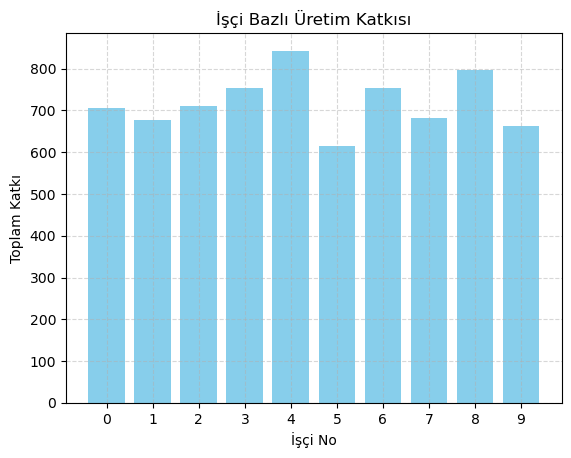

In [5]:
import matplotlib.pyplot as plt

worker_contrib = {j: 0 for j in range(n_workers)}
for _, row in assignments_df.iterrows():
    j = row['İşçi']
    i = row['Makine']
    worker_contrib[j] += skill_matrix[j, i] * machine_capacity[i]

plt.bar(worker_contrib.keys(), worker_contrib.values(), color="skyblue")
plt.xlabel("İşçi No")
plt.ylabel("Toplam Katkı")
plt.title("İşçi Bazlı Üretim Katkısı")
plt.xticks(range(n_workers))
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


/tmp/ipykernel_3482775/819101013.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_edges)  # 20 renkli palet (gerekirse genişletilir)
/tmp/ipykernel_3482775/819101013.py:42: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


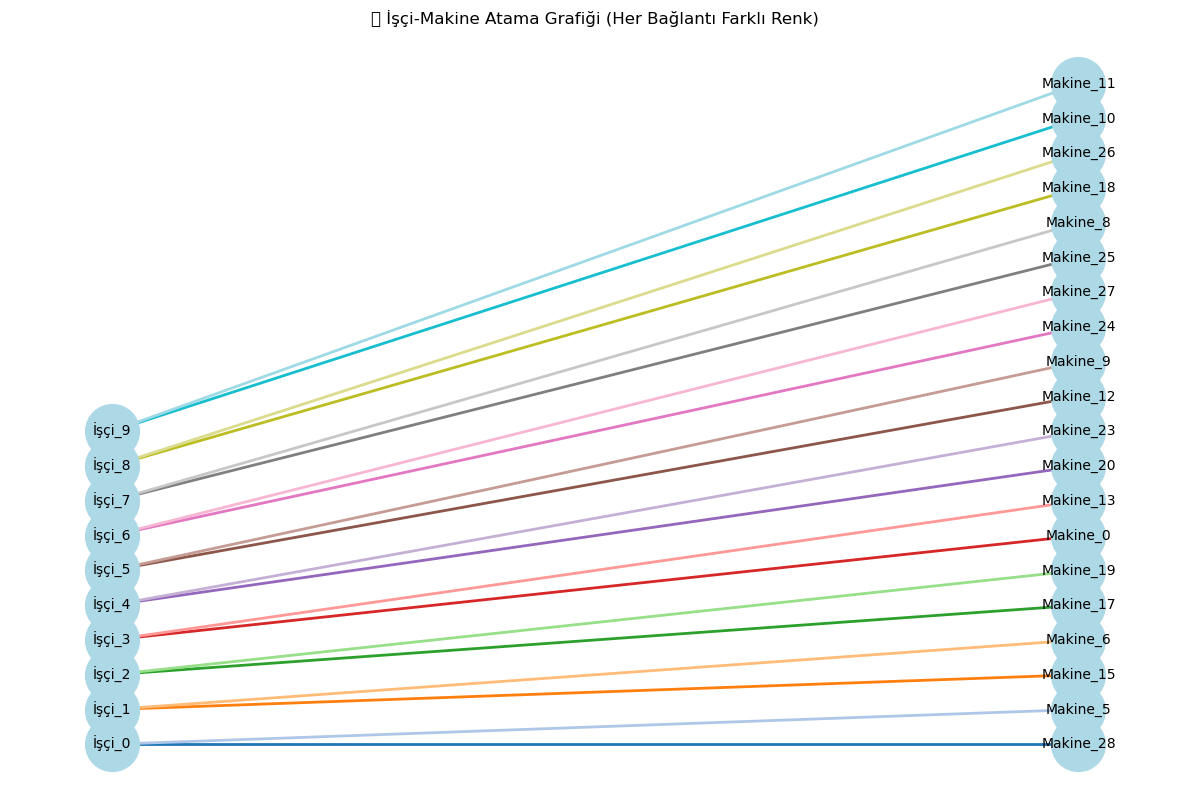

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# 🎯 İki taraflı grafik nesnesi oluştur
G = nx.Graph()

# İşçi ve Makine düğümleri
worker_nodes = [f"İşçi_{j}" for j in assignments_df["İşçi"].unique()]
machine_nodes = [f"Makine_{i}" for i in assignments_df["Makine"].unique()]

# Grafik düğümlerini ekle
G.add_nodes_from(worker_nodes, bipartite=0)
G.add_nodes_from(machine_nodes, bipartite=1)

# Atamalar (kenarlar)
edges = [(f"İşçi_{row['İşçi']}", f"Makine_{row['Makine']}") for _, row in assignments_df.iterrows()]
G.add_edges_from(edges)

# 🎨 Renk paleti: her kenar için farklı renk
num_edges = len(edges)
cmap = cm.get_cmap('tab20', num_edges)  # 20 renkli palet (gerekirse genişletilir)
edge_colors = [cmap(i) for i in range(num_edges)]

# 📍 Düğümlerin yerleşimi (katmanlı düzen)
pos = dict()
pos.update((node, (0, i)) for i, node in enumerate(worker_nodes))  # sol taraf
pos.update((node, (1, i)) for i, node in enumerate(machine_nodes))  # sağ taraf

# 🎨 Çizim
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=1500)
nx.draw_networkx_labels(G, pos, font_size=10)

# Kenarları tek tek çiz (her biri farklı renkte)
for i, edge in enumerate(edges):
    nx.draw_networkx_edges(G, pos, edgelist=[edge], edge_color=[edge_colors[i]], width=2)

plt.title("🎯 İşçi-Makine Atama Grafiği (Her Bağlantı Farklı Renk)")
plt.axis("off")
plt.tight_layout()
plt.show()


/tmp/ipykernel_3482775/1877788019.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(assignments_df))
/tmp/ipykernel_3482775/1877788019.py:56: UserWarning: Glyph 128295 (\N{WRENCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128295 (\N{WRENCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


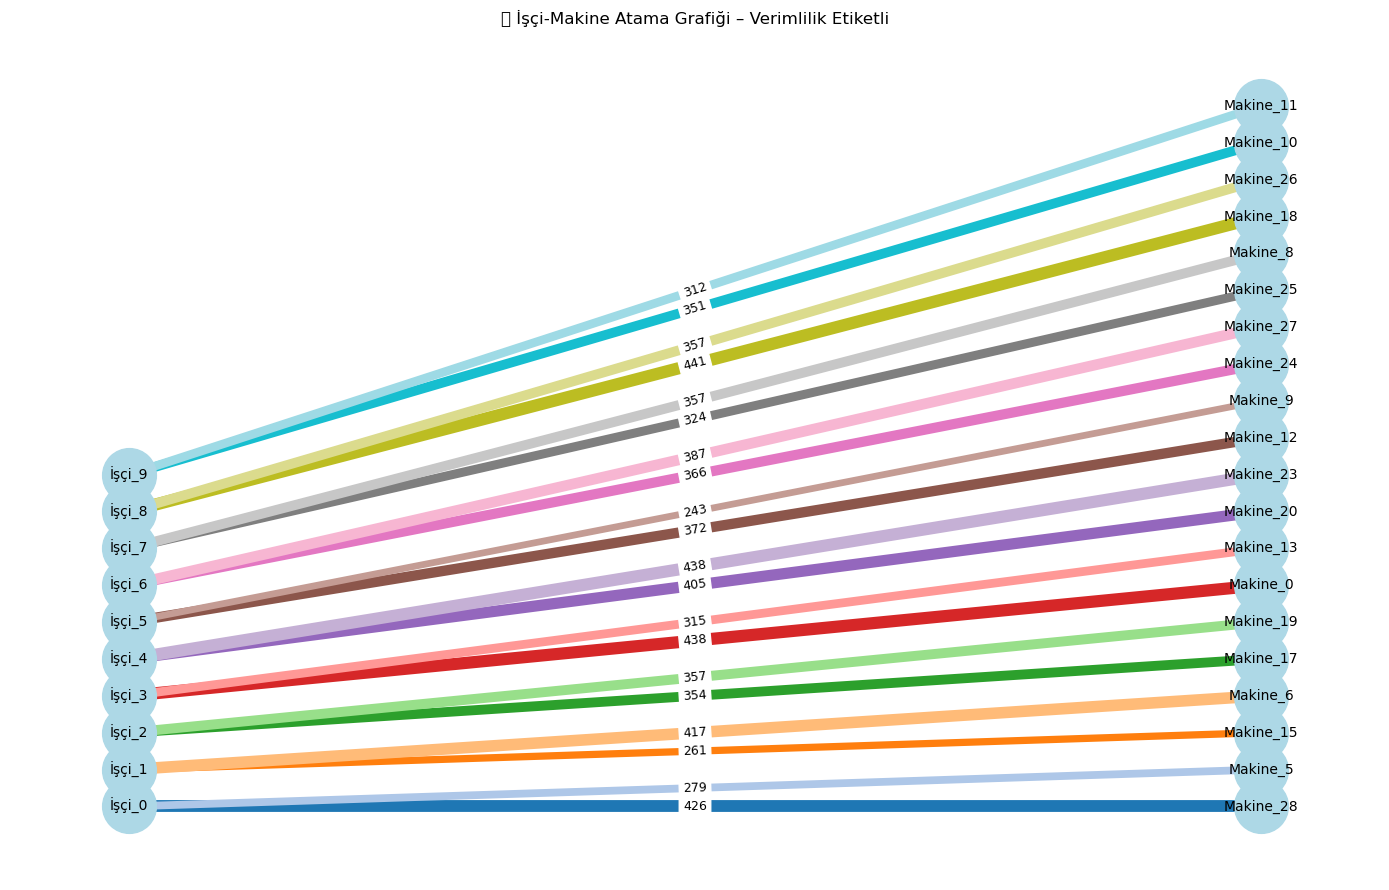

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# 🎯 Grafik oluştur
G = nx.Graph()

# Düğümleri ekle
worker_nodes = [f"İşçi_{j}" for j in assignments_df["İşçi"].unique()]
machine_nodes = [f"Makine_{i}" for i in assignments_df["Makine"].unique()]
G.add_nodes_from(worker_nodes, bipartite=0)
G.add_nodes_from(machine_nodes, bipartite=1)

# 🎨 Renk skalası
edges = []
edge_labels = {}
edge_weights = []
edge_colors = []

cmap = cm.get_cmap('tab20', len(assignments_df))

for idx, row in assignments_df.iterrows():
    j = row['İşçi']
    i = row['Makine']
    w_label = f"İşçi_{j}"
    m_label = f"Makine_{i}"

    # Verimlilik: skill × kapasite
    skill = skill_matrix[j, i]
    capacity = machine_capacity[i]
    efficiency = skill * capacity

    edge = (w_label, m_label)
    edges.append(edge)
    edge_labels[edge] = f"{efficiency}"
    edge_weights.append(efficiency / 50)  # kalınlık ölçeklemesi
    edge_colors.append(cmap(idx))

    G.add_edge(w_label, m_label)

# 📍 Pozisyonlama (katmanlı)
pos = dict()
pos.update((node, (0, i)) for i, node in enumerate(worker_nodes))
pos.update((node, (1, i)) for i, node in enumerate(machine_nodes))

# 📈 Grafik çizimi
plt.figure(figsize=(14, 9))
nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=1500)
nx.draw_networkx_labels(G, pos, font_size=10)

nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_colors, width=edge_weights)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

plt.title("🔧 İşçi-Makine Atama Grafiği – Verimlilik Etiketli")
plt.axis("off")
plt.tight_layout()
plt.show()
